In [1]:
import pandas as pd
import numpy as np
import os, glob
import datetime
import bisect
import math
import xlsxwriter
import matplotlib.pyplot as plt
from geopy.distance import geodesic

prgname = 'rsrp_gridwise_prediction_cumavg_mulnew.ipynb'

In [2]:
#This function decides the RSRP calss (RSRP: -156 to -31)
def get_rsrpclass(rsrpval):
    boundaries = [-156.0, -124.75, -93.5, -62.25, -31.0]
    num_of_clss = ['vbad','bad','good','vgood']
    dgt_of_clss = [0,1,2,3]
    index = bisect.bisect_right(boundaries, rsrpval)
    rsrp_class = num_of_clss[index-1]
    digit_class = dgt_of_clss[index-1]
    return rsrp_class,digit_class

print(get_rsrpclass(-35.))

('vgood', 3)


In [3]:
path = "/local/mnt3/workspace3/Kishore/ML_project_dir/ML_project_env/data_folder/signal_predicion_data/gps_cell_mergedata/SP_Kishore/"
all_files = glob.glob(os.path.join(path, "gps_cell*.csv"))
print(len(all_files))
nfls = len(all_files)

71


In [4]:
#pick the voluteer name
name2 = all_files[0].split("/")[-2]
name = name2.split("_")[-1]
print(name)

Kishore


#### picking all files (route= A or B) and arranging datewise

In [5]:
sroute = "ROUTE_A"                              #change ROUTE A/B
#filese reading from folder
route_files = []
for fle in all_files:
    df = pd.read_csv(fle,low_memory=True)
    numcols = len(df.columns)
    rte = sroute                             
    chk = df['route'].iloc[0]
    if(chk == rte):
        route_files.append(fle)
        
print(len(route_files))
#collecting the date from each file at selected route
dates = []
for fle in route_files:
    #print(fle)
    date1 = fle.split("/")[-1]
    seldate = date1[28:38]
    dates.append(seldate)
    
print(dates)
#sorting the dates and corresponding filenames are copied into array
dates_sort = [dates.index(x) for x in sorted(dates)]
dt_sort = np.asarray(dates_sort)
sorted_fls = np.empty((len(dates)), dtype=object)
for ii in range(len(route_files)):
    jj = dt_sort[ii]
    sorted_fls[ii] = route_files[jj]
    print(ii,jj,dt_sort[ii],route_files[jj])

21
['2023-06-26', '2023-06-28', '2023-08-02', '2023-07-13', '2023-08-14', '2023-06-21', '2023-07-20', '2023-06-22', '2023-08-15', '2023-06-29', '2023-07-18', '2023-08-17', '2023-07-05', '2023-07-06', '2023-08-16', '2023-07-25', '2023-07-11', '2023-06-15', '2023-06-27', '2023-07-12', '2023-07-10']
0 17 17 /local/mnt3/workspace3/Kishore/ML_project_dir/ML_project_env/data_folder/signal_predicion_data/gps_cell_mergedata/SP_Kishore/gps_cell_merge-null-unknown-2023-06-15-07-13-52-153000000-fill_out_your_user_id.csv
1 5 5 /local/mnt3/workspace3/Kishore/ML_project_dir/ML_project_env/data_folder/signal_predicion_data/gps_cell_mergedata/SP_Kishore/gps_cell_merge-null-unknown-2023-06-21-07-11-43-084000000-fill_out_your_user_id.csv
2 7 7 /local/mnt3/workspace3/Kishore/ML_project_dir/ML_project_env/data_folder/signal_predicion_data/gps_cell_mergedata/SP_Kishore/gps_cell_merge-null-unknown-2023-06-22-07-12-07-767000000-fill_out_your_user_id.csv
3 0 0 /local/mnt3/workspace3/Kishore/ML_project_dir/ML_

In [6]:
cnt=0; ii=-1
dates = []
list_pnts = []
flon = np.zeros((nfls,6500)) * np.nan
flat = np.zeros((nfls,6500)) * np.nan
frsrp = np.zeros((nfls,6500)) * np.nan
distt = np.zeros((nfls,6500))*np.nan
cdist = np.zeros((nfls,6500))*np.nan
for fle in sorted_fls:
    df = pd.read_csv(fle,low_memory=True)
    numcols = len(df.columns)
    #print("fname: {0}; no. of cloumns: {1}".format(fle, numcols))
    #display(df)
    #display(df.columns)
    rte = sroute
    chk = df['route'].iloc[0]
    if(chk == rte):
        cnt += 1
        print("fname: {0}; no. of rows: {1}".format(fle, len(df)))
        list_pnts.append(len(df))
        date1 = fle.split("/")[-1]
        seldate = date1[28:38]
        dates.append(seldate)
        
        df.drop(["index","GPS","cputime","speed","altitude","index.1",
                "route","cellinfo","cputime.1","ncells","type","rsrq",
                "sinr","rssi","level","dcpu"], axis=1, inplace=True)
        #display(df)
        
        lonn = df['Lon'].astype(float)
        latt = df['Lat'].astype(float)
        values = df['rsrp'].astype(float)
        np = len(lonn)
        ii += 1
        #display(np, ii, cnt)
        #distt = [0.0] * np
        #cdist = [0.0] * np
        cumdist = 0.0
        for kk in range(1,np):
            stpnt = (latt[kk-1],lonn[kk-1])
            endpnt = (latt[kk],lonn[kk])
            #geodesic distance calc. the distance on the surface of an ellipsoidal model of the earth (Karney 2013)
            distt[ii,kk-1] = geodesic(stpnt, endpnt).miles
            cumdist += distt[ii,kk-1]
            cdist[ii,kk-1] = round(cumdist, 3)
            flon[ii,kk-1] = lonn[kk-1]
            flat[ii,kk-1] = latt[kk-1]
            frsrp[ii,kk-1] = values[kk-1]
            #print(kk,latt[kk-1],lonn[kk-1],'   ',distt[ii,kk-1],'  ',cumdist)

print(f"Volunteer: {name}   route: {rte}   tot files: {cnt}")
rfls = (ii+1)
# rfls = 2
flon = flon[0:rfls,:]; flat = flat[0:rfls,:]
distt = distt[0:rfls,:]; cdist = cdist[0:rfls,:]
frsrp = frsrp[0:rfls,:]
print(flon.shape)

fname: /local/mnt3/workspace3/Kishore/ML_project_dir/ML_project_env/data_folder/signal_predicion_data/gps_cell_mergedata/SP_Kishore/gps_cell_merge-null-unknown-2023-06-15-07-13-52-153000000-fill_out_your_user_id.csv; no. of rows: 2779
fname: /local/mnt3/workspace3/Kishore/ML_project_dir/ML_project_env/data_folder/signal_predicion_data/gps_cell_mergedata/SP_Kishore/gps_cell_merge-null-unknown-2023-06-21-07-11-43-084000000-fill_out_your_user_id.csv; no. of rows: 2932
fname: /local/mnt3/workspace3/Kishore/ML_project_dir/ML_project_env/data_folder/signal_predicion_data/gps_cell_mergedata/SP_Kishore/gps_cell_merge-null-unknown-2023-06-22-07-12-07-767000000-fill_out_your_user_id.csv; no. of rows: 3250
fname: /local/mnt3/workspace3/Kishore/ML_project_dir/ML_project_env/data_folder/signal_predicion_data/gps_cell_mergedata/SP_Kishore/gps_cell_merge-null-unknown-2023-06-26-07-10-43-787000000-fill_out_your_user_id.csv; no. of rows: 3098
fname: /local/mnt3/workspace3/Kishore/ML_project_dir/ML_proj

In [7]:
#finding the minimum and maximum vals of longitude and latitudes
import numpy as np
lonmin=[]; lonmax=[]
latmin=[]; latmax=[]
for ii in range(rfls):
    londat = flon[ii,:]
    latdat = flat[ii,:]
    londata = londat[~np.isnan(londat)]
    latdata = latdat[~np.isnan(latdat)]
    minlon = min(londata); maxlon=max(londata)
    minlat = min(latdata); maxlat = max(latdata)
    lonmin.append(minlon); lonmax.append(maxlon)
    latmin.append(minlat); latmax.append(maxlat)

minlong = min(lonmin); maxlong = max(lonmax)
minlatt = min(latmin); maxlatt = max(latmax)
print(f"min_longitude: {minlong}    max_longitude: {maxlong}")
print(f"min_latitude: {minlatt}    max_latitude: {maxlatt}")

min_longitude: -117.67491056    max_longitude: -117.18853983
min_latitude: 32.88834191    max_latitude: 33.52094565


In [8]:
#fixing the grids (0.1 mile = 40 x 40)
nx = 50
ny = 50
deltax = (maxlong - minlong)/nx
deltay = (maxlatt - minlatt)/ny
print(deltax,deltay)

0.009727414600000088 0.012652074800000008


In [9]:
#distance calcs. using lon, lats grids
slat = minlatt
for clms in range(3):
    slon = minlong
    elat = slat + deltay
    for rws in range(3):
        elon = slon + deltax
        #print(clms,rws,slon,elon, ' ',elon-slon,' ',slat,elat,elat-slat)
        stpnt = (slat,slon)
        endpnt = (elat,elon)
        diss = geodesic(stpnt,endpnt).miles
        print('distance: ',diss)
        
        slon = elon
    slat = elat


distance:  1.039227802700331
distance:  1.039227802700331
distance:  1.039227802700331
distance:  1.0391855323146506
distance:  1.0391855323146506
distance:  1.0391855323146506
distance:  1.0391432517135442
distance:  1.0391432517135442
distance:  1.0391432517135442


In [10]:
plon = flon[0,:]
plat = flat[0,:]
prsrp = frsrp[0,:]
#picking the non NaN indices values
nindxs = np.where(~np.isnan(plon))
lonp = plon[nindxs]
latp = plat[nindxs]
rsrpp = prsrp[nindxs]
print(len(plon),len(plat),len(prsrp),len(lonp),len(latp),len(rsrpp))

6500 6500 6500 2778 2778 2778


In [11]:
grsrp = np.zeros((rfls,nx*ny)) * np.nan
glon = np.zeros((rfls,nx*ny))*np.nan
glat = np.zeros((rfls,nx*ny))*np.nan
gpnts = np.zeros((rfls,nx*ny))*np.nan
clss_txt = np.empty((rfls,nx*ny), dtype=object)
clss_dgt = np.zeros((rfls,nx*ny), dtype=int)*np.nan
dly_rsrp = np.zeros((rfls,nx,ny,8000))*np.nan
dly_cnt = np.zeros((rfls,nx,ny))*np.nan
# slat = minlatt; allcnt = 0; jj = -1

tcnt = 0
for nf in range(rfls):
    #picking the each grid RSRP values: count, RSRP mean, predictions at each grid
    plon = flon[nf,:]
    plat = flat[nf,:]
    prsrp = frsrp[nf,:]
    #picking the non NaN indices values
    nindxs = np.where(~np.isnan(plon))
    lonp = plon[nindxs]
    latp = plat[nindxs]
    rsrpp = prsrp[nindxs]
    #print(nf,len(plon),len(plat),len(prsrp),len(lonp),len(latp),len(rsrpp))
    
    slat = minlatt; allcnt = 0; jj = -1
    for clms in range(ny):
        slon = minlong
        elat = slat + deltay
        for rws in range(nx):
            elon = slon + deltax
            cnt = 0; totrsrp = 0.0
            jj+=1
            for kk in range(len(rsrpp)):
                if(((lonp[kk]>=slon) & (lonp[kk]<elon)) & ((latp[kk]>=slat) & (latp[kk]<elat))):
                    #cnt += 1
                    if((rsrpp[kk] >= -156.0) & (rsrpp[kk] <= -31.0) & (~np.isnan(rsrpp[kk]))):
                        cnt += 1
                        totrsrp = totrsrp + rsrpp[kk]
                        dly_rsrp[nf,rws,clms,cnt] = rsrpp[kk]
                    #if((nf == 0) &(jj == 963)):
                        #print(nf,rws,clms,rsrpp[kk])
                    #print(kk,slon,elon,slat,elat,'  ',lonp[kk],latp[kk],cnt,rsrpp[kk])
            if(cnt > 0): avgrsrp = totrsrp/cnt
            if(cnt <=0): avgrsrp = np.nan
            allcnt = allcnt + cnt
            dly_cnt[nf,rws,clms] = cnt
                
            #jj +=1
            glon[nf,jj] = (slon + elon)/2
            glat[nf,jj] = (slat + elat)/2
            grsrp[nf,jj] = avgrsrp
            gpnts[nf,jj] = cnt
        
            #if(jj == 963):
            #    print(nf,rws,clms)
            if(avgrsrp == 0.0): avgrsrp = np.nan
            if(avgrsrp > -31.0): avgrsrp = -32.0
            #if(nf == 0):
                #print(nf,glon[nf,jj],glat[nf,jj],avgrsrp)
            if math.isnan(avgrsrp):
                clss_txt[nf,jj] = 'NaN'
                clss_dgt[nf,jj] = np.nan
                #print(j,k,mnepred[k,j],dgtpred[k,j])
            else:
                resm = get_rsrpclass(avgrsrp)
                clss_txt[nf,jj] = resm[0]
                clss_dgt[nf,jj] = int(resm[1])
            #print(slon,elon,slat,elat,cnt,avgrsrp,allcnt,clss_txt[nf,jj],'********************')
           
            slon = elon
        slat = elat
    #print(len(rsrpp),allcnt)
    print(f"{nf} volunteer: {name}, route: {rte}, date: {dates[nf]} completed")

0 volunteer: Kishore, route: ROUTE_A, date: 2023-06-15 completed
1 volunteer: Kishore, route: ROUTE_A, date: 2023-06-21 completed
2 volunteer: Kishore, route: ROUTE_A, date: 2023-06-22 completed
3 volunteer: Kishore, route: ROUTE_A, date: 2023-06-26 completed
4 volunteer: Kishore, route: ROUTE_A, date: 2023-06-27 completed
5 volunteer: Kishore, route: ROUTE_A, date: 2023-06-28 completed
6 volunteer: Kishore, route: ROUTE_A, date: 2023-06-29 completed
7 volunteer: Kishore, route: ROUTE_A, date: 2023-07-05 completed
8 volunteer: Kishore, route: ROUTE_A, date: 2023-07-06 completed
9 volunteer: Kishore, route: ROUTE_A, date: 2023-07-10 completed
10 volunteer: Kishore, route: ROUTE_A, date: 2023-07-11 completed
11 volunteer: Kishore, route: ROUTE_A, date: 2023-07-12 completed
12 volunteer: Kishore, route: ROUTE_A, date: 2023-07-13 completed
13 volunteer: Kishore, route: ROUTE_A, date: 2023-07-18 completed
14 volunteer: Kishore, route: ROUTE_A, date: 2023-07-20 completed
15 volunteer: Kishor

In [12]:
#This is for mean RSRP values are saving into csv values
outpath= "/local/mnt3/workspace3/Kishore/ML_project_dir/ML_project_env/data_folder/test/signal_prediction_plots/16Aug2023/"
dist = float("{:.2f}".format(diss))
csvfname = outpath+name +'_'+rte+'_'+str(nx)+'x'+str(ny)+'_'+str(dist)+'mile_RSRP_observationscheck.csv'
xlsfname = outpath+name +'_'+rte+'_'+str(nx)+'x'+str(ny)+'_'+str(dist)+'mile_RSRP_observationscheck.xls'
print(csvfname)

# obsdf = pd.DataFrame(list(zip(clss_dgt[0,:],clss_dgt[1,:],clss_dgt[2,:],clss_dgt[3,:],clss_dgt[4,:])),
#                      columns=["0thday","1day","2day",'3day','4day'])
obsdf = pd.DataFrame(list(zip(clss_dgt[0,:],clss_dgt[1,:],clss_dgt[2,:],clss_dgt[3,:])),
                     columns=["0thday","1day","2day",'3day'])

display(obsdf[0:10])
obsdf.to_csv(csvfname, index=False)
obsdf.to_excel(xlsfname, index=False)

/local/mnt3/workspace3/Kishore/ML_project_dir/ML_project_env/data_folder/test/signal_prediction_plots/16Aug2023/Kishore_ROUTE_A_50x50_1.04mile_RSRP_observationscheck.csv


0thday  1day  2day  3day
0     NaN   NaN   NaN   NaN
1     NaN   NaN   NaN   NaN
2     NaN   NaN   NaN   NaN
3     NaN   NaN   NaN   NaN
4     NaN   NaN   NaN   NaN
5     NaN   NaN   NaN   NaN
6     NaN   NaN   NaN   NaN
7     NaN   NaN   NaN   NaN
8     NaN   NaN   NaN   NaN
9     NaN   NaN   NaN   NaN

In [13]:
print(dly_rsrp.shape, grsrp.shape)

(21, 50, 50, 8000) (21, 2500)


In [14]:
#cumlative mean: day1 mean = sum(day1 values)/len(day1); day2 mean= sum(day1+day2 values)/len(day1+day2)
kk =-1
cumclss_txt = np.empty((rfls,nx*ny), dtype=object)
cumclss_dgt = np.zeros((rfls,nx*ny)) * np.nan
cumdlycnt = np.zeros((rfls,nx*ny)) * np.nan
cumdlyavg = np.zeros((rfls,nx*ny)) * np.nan
for clm in range(ny):
    for rws in range(nx):
        tot = 0; tcnt = 0
        kk += 1
        totdata1 =[]
        for nf in range(rfls):
            data1 = dly_rsrp[0:nf+1,rws,clm,:]; cdata1 = dly_cnt[0:nf+1,rws,clm]
            data = data1[~np.isnan(data1)]; cdata = cdata1[~np.isnan(cdata1)]
            #if((rws <10) & (clm <10)):
            #    print(nf,rws,clm,'  ',dly_cnt[nf,rws,clm],dly_cnt[0:nf+1,rws,clm])
            
            #merging the day by day
            #totdata1.extend(data)
            totdata1 = data
            totdata = np.asarray(totdata1)
            
            ###cum RSRP mean
            if(len(totdata) == 0): cdmean = np.nan
            if(len(totdata) > 0):
                gd = np.where((totdata >= -156.0) & (totdata <= -31.0))[0]
                cdmean = sum(totdata[gd])/len(gd)
            cumdlyavg[nf,kk] = cdmean   
            ###cum RSRP points mean
            cdat = np.asarray(cdata)
            if(len(cdat)< 0): cumdlycnt[nf,kk] = np.nan
            if(len(cdat) > 0): cumdlycnt[nf,kk] = (sum(cdat))/len(cdat)
            if(cumdlycnt[nf,kk] == 0.0): cumdlycnt[nf,kk] = np.nan
            #print(nf,rws,clm,'  ',dly_cnt[nf,rws,clm],dly_cnt[0:nf+1,rws,clm],cdat,len(cdat),cumdlycnt[nf,kk])
            
            if math.isnan(cdmean):
                cumclss_txt[nf,kk] = 'NaN'
                cumclss_dgt[nf,kk] = np.nan
                #print(j,k,mnepred[k,j],dgtpred[k,j])
            else:
                resm = get_rsrpclass(cdmean)
                cumclss_txt[nf,kk] = resm[0]
                cumclss_dgt[nf,kk] = int(resm[1])
                
            #print(nf,clm,rws,cumdlyavg[nf,kk])
print(cumclss_dgt.shape,cumclss_txt.shape)

(21, 2500) (21, 2500)


In [15]:
#This is for cumulative mean RSRP values are saving into csv values
outpath= "/local/mnt3/workspace3/Kishore/ML_project_dir/ML_project_env/data_folder/test/signal_prediction_plots/16Aug2023/"
dist = float("{:.2f}".format(diss))
csvfname = outpath+name +'_'+rte+'_'+str(nx)+'x'+str(ny)+'_'+str(dist)+'mile_RSRP_predictionscheck.csv'
xlsfname = outpath+name +'_'+rte+'_'+str(nx)+'x'+str(ny)+'_'+str(dist)+'mile_RSRP_predictionscheck.xls'
print(csvfname)

preddf = pd.DataFrame(list(zip(cumclss_dgt[0,:],cumclss_dgt[1,:],cumclss_dgt[2,:],cumclss_dgt[3,:])),
                     columns=["0thday","[0-1]days","[0-2]days",'[0-3]days'])

display(preddf[0:10])
preddf.to_csv(csvfname, index=False)
preddf.to_excel(xlsfname, index=False)

/local/mnt3/workspace3/Kishore/ML_project_dir/ML_project_env/data_folder/test/signal_prediction_plots/16Aug2023/Kishore_ROUTE_A_50x50_1.04mile_RSRP_predictionscheck.csv


0thday  [0-1]days  [0-2]days  [0-3]days
0     NaN        NaN        NaN        NaN
1     NaN        NaN        NaN        NaN
2     NaN        NaN        NaN        NaN
3     NaN        NaN        NaN        NaN
4     NaN        NaN        NaN        NaN
5     NaN        NaN        NaN        NaN
6     NaN        NaN        NaN        NaN
7     NaN        NaN        NaN        NaN
8     NaN        NaN        NaN        NaN
9     NaN        NaN        NaN        NaN

##### Predictions Plotting (each grid RSRP points, RSRP mean, predictions) for each route

In [16]:
for nf in range(rfls):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,8))
    rlon = glon[nf,:]; rlat = glat[nf,:]
    rpnts = cumdlycnt[nf,:]; 
    
    rrsrp = cumdlyavg[nf,:]
    rrsrp[rrsrp == 0.0] = np.nan
    rpnts[rpnts == 0.0] = np.nan
    #left plot (row=1,column=1)
    rpnts[rpnts == 0.0] = np.nan
    sc = ax1.scatter(rlon, rlat, c=rpnts, cmap='jet',  s=100., alpha=0.65, linewidths=6)
    for ii in range(ny+1):
        yval = minlatt + deltay*ii
        ax1.hlines(y=yval,xmin=minlong, xmax=maxlong,linewidth=1,color='gray',linestyles='--',alpha=0.45)
    for ii in range(nx+1):
        xval = minlong + deltax*ii
        ax1.vlines(x=xval,ymin=minlatt-.001, ymax=maxlatt,linewidth=1,color='gray',linestyles='--',alpha=0.45)

    ax1.set_xlim(minlong,maxlong)
    ax1.set_ylim(minlatt,maxlatt)
    ax1.tick_params(axis='x',rotation=30)
    cbar = plt.colorbar(sc,ax=ax1)
    cbar.set_label('RSRP count',fontsize=20)
    if(nf ==0):
        tit = name + '   ' + rte +'  '+dates[nf]
    else:    
        tit = name + '   ' + rte +'  '+dates[nf]+' [0-' +str(nf)+']'
    ax1.set_title(tit,fontsize=14,weight='bold')
    
    #right plot (row=1, column=2)
    sc = ax2.scatter(rlon, rlat, c=rrsrp, cmap='jet',  s=100., alpha=0.65, linewidths=6)
    for ii in range(ny+1):
        yval = minlatt + deltay*ii
        ax2.hlines(y=yval,xmin=minlong, xmax=maxlong,linewidth=1,color='gray',linestyles='--',alpha=0.45)
    for ii in range(nx+1):
        xval = minlong + deltax*ii
        ax2.vlines(x=xval,ymin=minlatt-.001, ymax=maxlatt,linewidth=1,color='gray',linestyles='--',alpha=0.45)
    cbar = plt.colorbar(sc,ticks=[-156,-150,-140,-130,-120,-110,-100,-90,-80,-70,-60,-50,-40,-35,-31],ax=ax2)
    cbar.set_label('RSRP',fontsize=20)
    sc.set_clim(-156,-31.) 
    ax2.set_xlim(minlong,maxlong)
    ax2.set_ylim(minlatt,maxlatt)
    ax2.tick_params(axis='x',rotation=30)
    
    if(nf ==0):
        tit = name + '   ' + rte +'  '+dates[nf]
    else:    
        tit = name + '   ' + rte +'  '+dates[nf]+' [0-' +str(nf)+']'

    ax2.set_title(tit,fontsize=14,weight='bold')
    plt.annotate(prgname, xy=(0.08,0.02), xycoords='figure fraction', ha='left',color='black',fontsize=8)
    
#     #save image
#     outpath= "/local/mnt3/workspace3/Kishore/ML_project_dir/ML_project_env/data_folder/test/signal_prediction_plots/16Aug2023/"
#     vfname = outpath+name +'_'+rte+'_'+dates[nf]+ '_RSRP_cell_gps_gridwise_cumavg_prdctns1.png'
#     print(vfname)
#     fig.savefig(vfname)
    
    plt.close()

In [17]:
for nf in range(rfls):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,8))
    rlon = glon[nf,:]; rlat = glat[nf,:]
    rpnts = gpnts[nf,:]; rclss_txt = cumclss_txt[nf,:]
    rclss_dgt = cumclss_dgt[nf,:]
    #left plot (row=1,column=1)
    rpnts[rpnts == 0.0] = np.nan
    for ij in range(len(rclss_dgt)):
        if(rclss_txt[ij] != 'NaN'):
            ax1.text(rlon[ij]-0.0015, rlat[ij],rclss_txt[ij],fontsize=11,weight='bold') 

    for ii in range(ny+1):
        yval = minlatt + deltay*ii
        ax1.hlines(y=yval,xmin=minlong, xmax=maxlong,linewidth=1,color='gray',linestyles='--',alpha=0.45)
    for ii in range(nx+1):
        xval = minlong + deltax*ii
        ax1.vlines(x=xval,ymin=minlatt-.001, ymax=maxlatt,linewidth=1,color='gray',linestyles='--',alpha=0.45)

    ax1.set_xlim(minlong,maxlong)
    ax1.set_ylim(minlatt,maxlatt)
    ax1.tick_params(axis='x',rotation=30)
    if(nf ==0):
        tit = name + '   ' + rte +'  '+dates[nf]
    else:    
        tit = name + '   ' + rte +'  '+dates[nf]+' [0-' +str(nf)+']'
    
    ax1.set_title(tit,fontsize=14,weight='bold')
    
    #right plot (row=1, column=2)
    rpnts[rpnts == 0.0] = np.nan
    sc = ax2.scatter(rlon, rlat, c=rpnts, cmap='jet',  s=0., alpha=0.65, linewidths=6)
    rclss_dgt = (np.rint(rclss_dgt)).astype(int)
    for ij in range(len(rclss_dgt)):
        if(rclss_txt[ij] != 'NaN'):
            ax2.text(rlon[ij]-0.0005, rlat[ij]-0.0005,rclss_dgt[ij],fontsize=14,weight='bold') 

    for ii in range(ny+1):
        yval = minlatt + deltay*ii
        ax2.hlines(y=yval,xmin=minlong, xmax=maxlong,linewidth=1,color='gray',linestyles='--',alpha=0.45)
    for ii in range(nx+1):
        xval = minlong + deltax*ii
        ax2.vlines(x=xval,ymin=minlatt-.001, ymax=maxlatt,linewidth=1,color='gray',linestyles='--',alpha=0.45)

    ax2.set_xlim(minlong,maxlong)
    ax2.set_ylim(minlatt,maxlatt)
    ax2.tick_params(axis='x',rotation=30)
    if(nf ==0):
        tit = name + '   ' + rte +'  '+dates[nf]
    else:    
        tit = name + '   ' + rte +'  '+dates[nf]+' [0-' +str(nf)+']'
    
    ax2.set_title(tit,fontsize=14,weight='bold')
    plt.annotate(prgname, xy=(0.08,0.02), xycoords='figure fraction', ha='left',color='black',fontsize=8)
    
#      #save image
#     outpath= "/local/mnt3/workspace3/Kishore/ML_project_dir/ML_project_env/data_folder/test/signal_prediction_plots/"
#     vfname = outpath+name +'_'+rte+'_'+dates[nf]+ '_RSRP_cell_gps_gridwise_cumavg_prdctns2.png'
#     print(vfname)
#     fig.savefig(vfname)
    
    plt.close()


In [18]:
print(clss_txt.shape,clss_dgt.shape,cumclss_txt.shape,cumclss_dgt.shape)

(21, 2500) (21, 2500) (21, 2500) (21, 2500)


In [19]:
#each class acuuracies at each day
clss = ['vbad','bad','good','vgood']
accurcy = np.zeros((rfls,4))
overall_acc= []; 
for k in range(0,rfls-1):
    obs_clsdgt = clss_dgt[k+1,:]
    pred_clsdgt = cumclss_dgt[k,:]
    numnan = 0
    alltp = 0
    allog = 0
    for j in range(4):
        og_dgt = (np.rint(obs_clsdgt)).astype(int)   
        og = np.where(og_dgt == j)
    
        pg_dgt = (np.rint(pred_clsdgt)).astype(int)
        pg = np.where(pg_dgt == j)
        #print(len(og[0]),len(pg[0]))
        tp =0
        for item in og[0]:
            #print("data:",item,pg_dgt[item],og_dgt[item],pred_clsdgt[item])
            if(item in pg[0]):
                tp +=1
            if(math.isnan(pred_clsdgt[item])):
                numnan +=1
                
        #print('Nones:',numnan)
        alltp += tp
        allog += len(og[0])
        if((len(og[0])-numnan) > 0): 
            acc = 100.* tp / (len(og[0])-numnan)
        else:
            acc = 0.0
        print(k,j,"accuracy:",acc)
        accurcy[k,j] = acc
    
    allacc = 100.*(alltp/allog)
    overall_acc.append(allacc)      
    print(k,'overall:',overall_acc[k-1])
#     print(k,obs_clsdgt.shape,pred_clsdgt.shape)

0 0 accuracy: 0.0
0 1 accuracy: 80.51948051948052
0 2 accuracy: 104.76190476190476
0 3 accuracy: 0.0
0 overall: 84.0
1 0 accuracy: 0.0
1 1 accuracy: 91.66666666666667
1 2 accuracy: 67.5
1 3 accuracy: 0.0
1 overall: 84.0
2 0 accuracy: 0.0
2 1 accuracy: 80.26315789473684
2 2 accuracy: 72.0
2 3 accuracy: 0.0
2 overall: 81.1881188118812
3 0 accuracy: 0.0
3 1 accuracy: 85.33333333333333
3 2 accuracy: 72.0
3 3 accuracy: 0.0
3 overall: 78.21782178217822
4 0 accuracy: 0.0
4 1 accuracy: 94.23076923076923
4 2 accuracy: 58.333333333333336
4 3 accuracy: 0.0
4 overall: 81.1881188118812
5 0 accuracy: 0.0
5 1 accuracy: 95.08196721311475
5 2 accuracy: 73.6842105263158
5 3 accuracy: 0.0
5 overall: 76.23762376237624
6 0 accuracy: 0.0
6 1 accuracy: 82.05128205128206
6 2 accuracy: 100.0
6 3 accuracy: 0.0
6 overall: 86.86868686868688
7 0 accuracy: 0.0
7 1 accuracy: 92.1875
7 2 accuracy: 71.42857142857143
7 3 accuracy: 0.0
7 overall: 85.85858585858585
8 0 accuracy: 0.0
8 1 accuracy: 90.625
8 2 accuracy: 69.

In [20]:
print(accurcy[:,1])
print(overall_acc)

[80.51948052 91.66666667 80.26315789 85.33333333 94.23076923 95.08196721
 82.05128205 92.1875     90.625      85.33333333 96.49122807 83.33333333
 97.72727273 85.13513514 97.61904762 80.82191781 90.90909091 88.63636364
 84.28571429 78.48101266  0.        ]
[84.0, 81.1881188118812, 78.21782178217822, 81.1881188118812, 76.23762376237624, 86.86868686868688, 85.85858585858585, 84.84848484848484, 82.17821782178217, 85.0, 83.6734693877551, 84.0, 72.27722772277228, 86.73469387755102, 72.72727272727273, 80.0, 88.11881188118812, 69.0, 84.0, 81.1881188118812]


In [21]:
outpath= "/local/mnt3/workspace3/Kishore/ML_project_dir/ML_project_env/data_folder/test/signal_prediction_plots/16Aug2023/"
dist = float("{:.2f}".format(diss))
csvfname = outpath+name +'_'+rte+'_'+str(nx)+'x'+str(ny)+'_'+str(dist)+'mile_RSRP_meanpredictions.csv'
xlsfname = outpath+name +'_'+rte+'_'+str(nx)+'x'+str(ny)+'_'+str(dist)+'mile_RSRP_meanpredictions.xls'
print(csvfname)

accs = accurcy[0:,:]
outdf = pd.DataFrame(list(zip(accs[:,0],accs[:,1],accs[:,2],accs[:,3],overall_acc)),
                     columns=["vbad","bad","good",'vgood',"overall"])

outdf
outdf.to_csv(csvfname, index=False)
outdf.to_excel(xlsfname,index=False)

/local/mnt3/workspace3/Kishore/ML_project_dir/ML_project_env/data_folder/test/signal_prediction_plots/16Aug2023/Kishore_ROUTE_A_50x50_1.04mile_RSRP_meanpredictions.csv


In [22]:
outdf

vbad        bad        good  vgood    overall
0    0.0  80.519481  104.761905    0.0  84.000000
1    0.0  91.666667   67.500000    0.0  81.188119
2    0.0  80.263158   72.000000    0.0  78.217822
3    0.0  85.333333   72.000000    0.0  81.188119
4    0.0  94.230769   58.333333    0.0  76.237624
5    0.0  95.081967   73.684211    0.0  86.868687
6    0.0  82.051282  100.000000    0.0  85.858586
7    0.0  92.187500   71.428571    0.0  84.848485
8    0.0  90.625000   69.444444    0.0  82.178218
9    0.0  85.333333   87.500000    0.0  85.000000
10   0.0  96.491228   65.853659    0.0  83.673469
11   0.0  83.333333   86.363636    0.0  84.000000
12   0.0  97.727273   52.631579    0.0  72.277228
13   0.0  85.135135   95.652174    0.0  86.734694
14   0.0  97.619048   55.357143    0.0  72.727273
15   0.0  80.821918   77.777778    0.0  80.000000
16   0.0  90.909091   82.857143    0.0  88.118812
17   0.0  88.636364   53.571429    0.0  69.000000
18   0.0  84.285714   86.206897    0.0  84.000000
19   0.0  78.481013   90.909091    0.0  81.188119

observations count: 100  accurate predictions: 84  overall accuracy: 84.0
observations count: 101  accurate predictions: 82  overall accuracy: 81.188
observations count: 101  accurate predictions: 79  overall accuracy: 78.218
observations count: 101  accurate predictions: 82  overall accuracy: 81.188
observations count: 101  accurate predictions: 77  overall accuracy: 76.238
observations count: 99  accurate predictions: 86  overall accuracy: 86.869
observations count: 99  accurate predictions: 85  overall accuracy: 85.859
observations count: 99  accurate predictions: 84  overall accuracy: 84.848
observations count: 101  accurate predictions: 83  overall accuracy: 82.178
observations count: 100  accurate predictions: 85  overall accuracy: 85.0
observations count: 98  accurate predictions: 82  overall accuracy: 83.673
observations count: 100  accurate predictions: 84  overall accuracy: 84.0
observations count: 101  accurate predictions: 73  overall accuracy: 72.277
observations count: 98

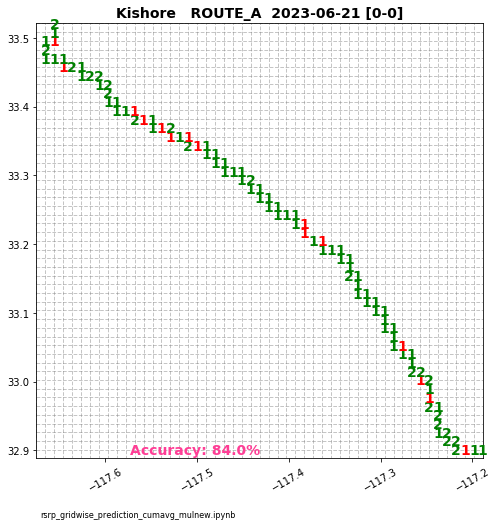

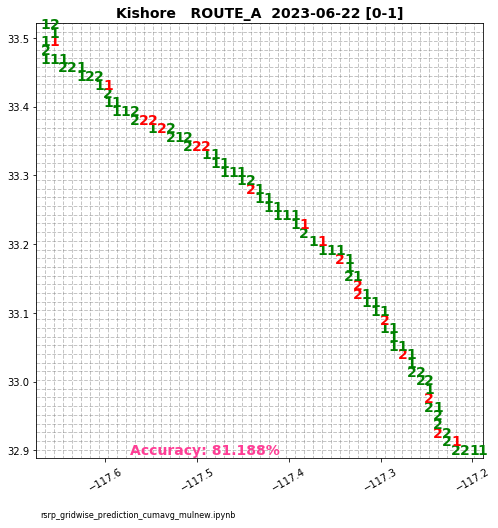

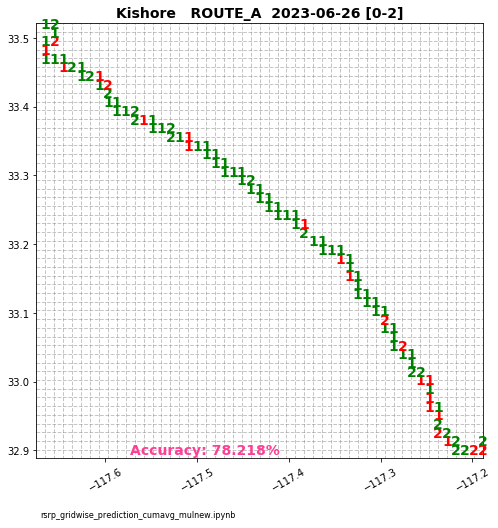

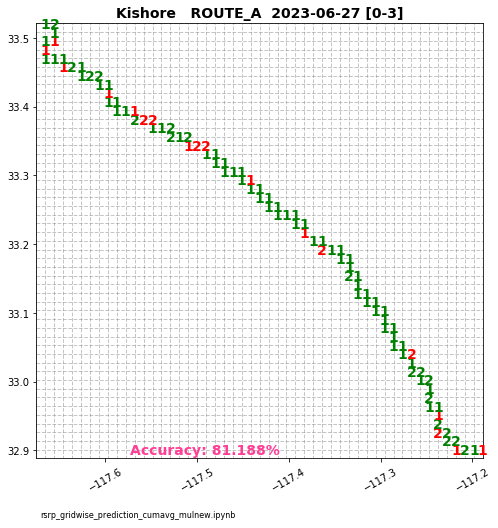

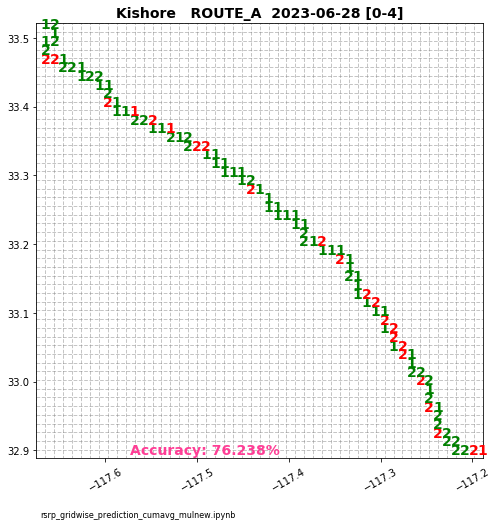

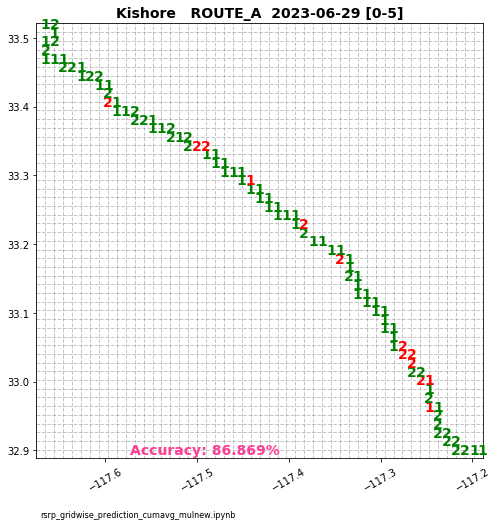

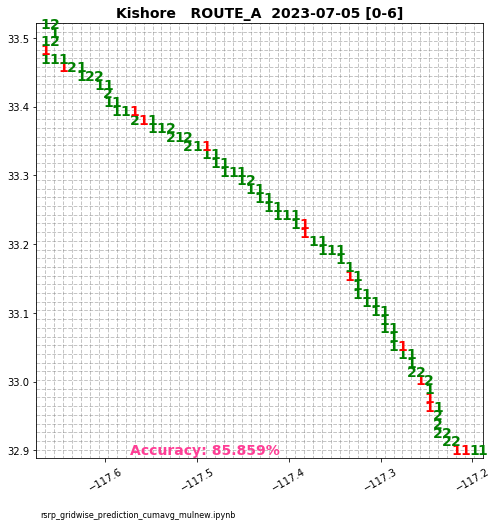

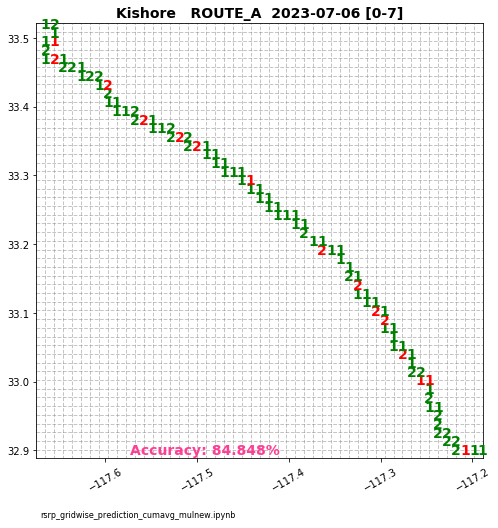

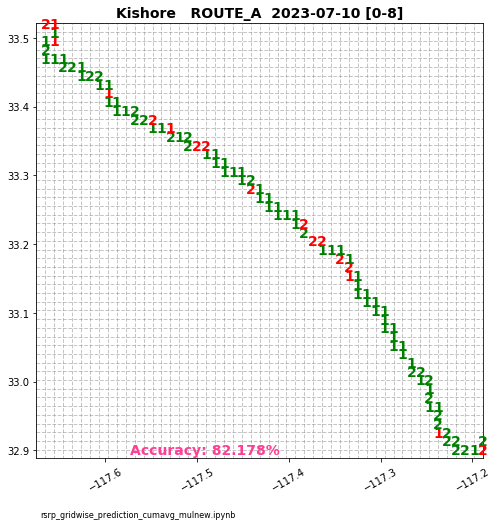

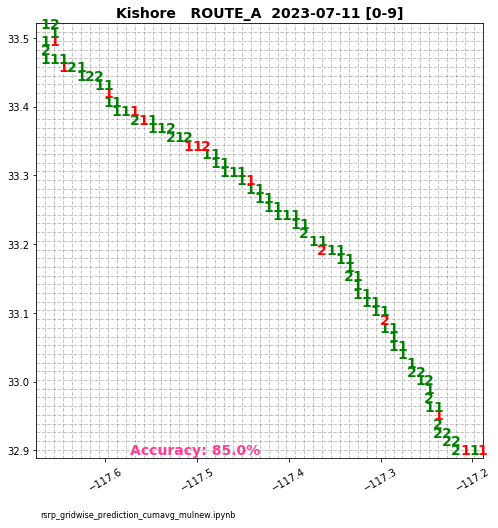

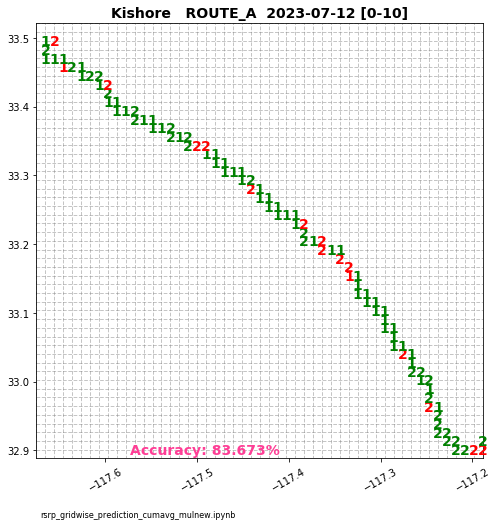

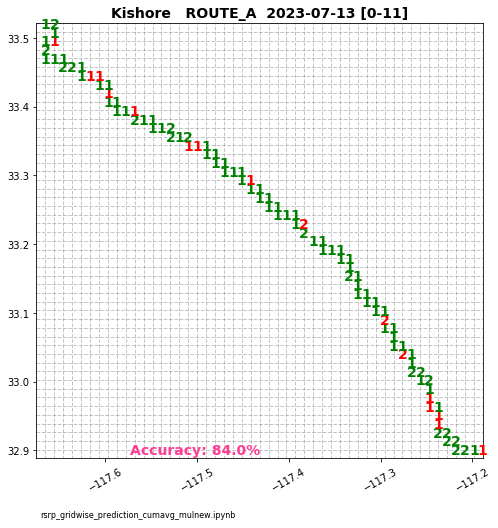

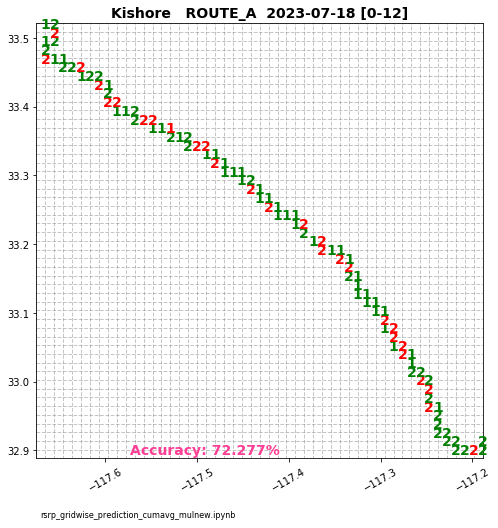

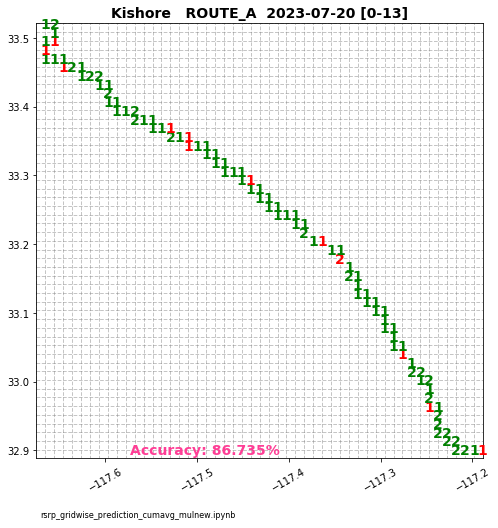

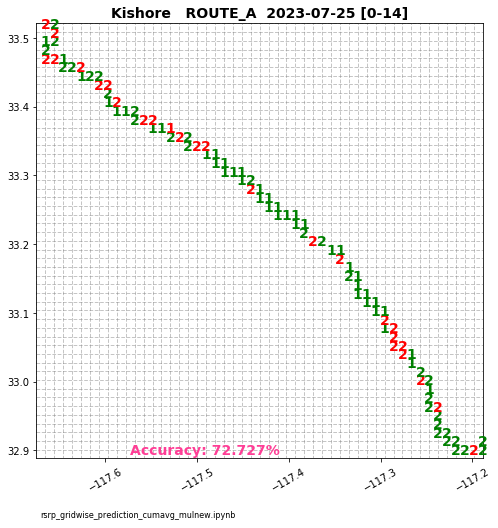

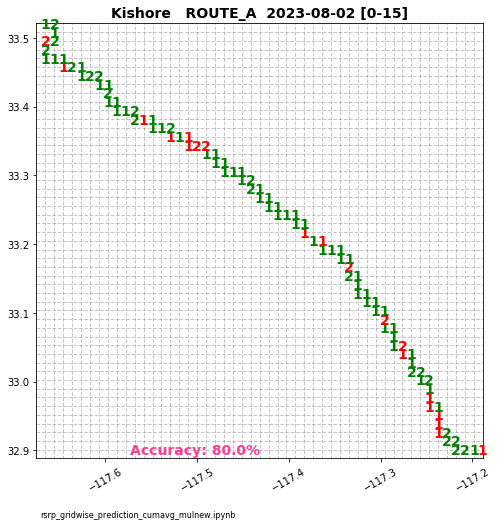

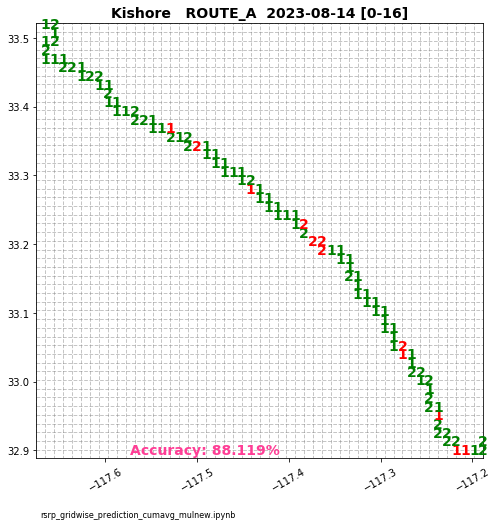

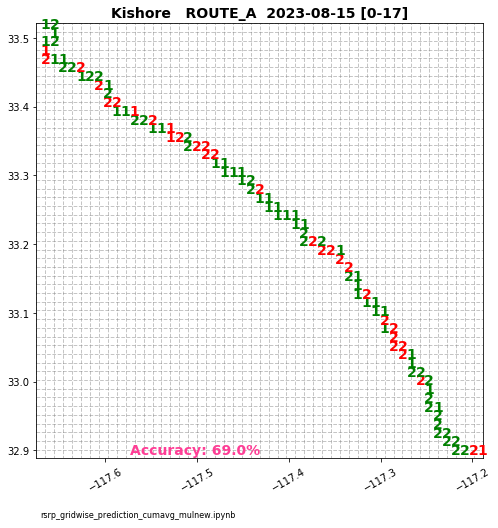

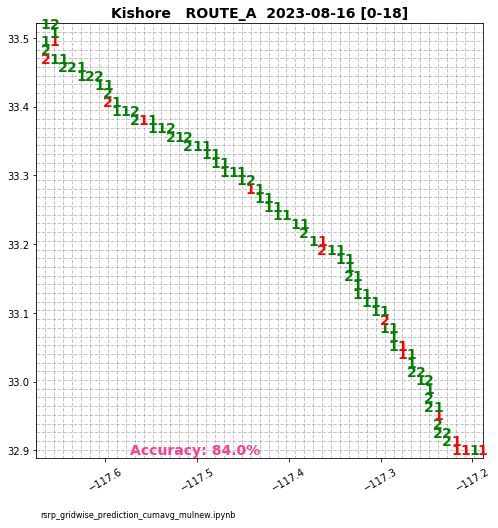

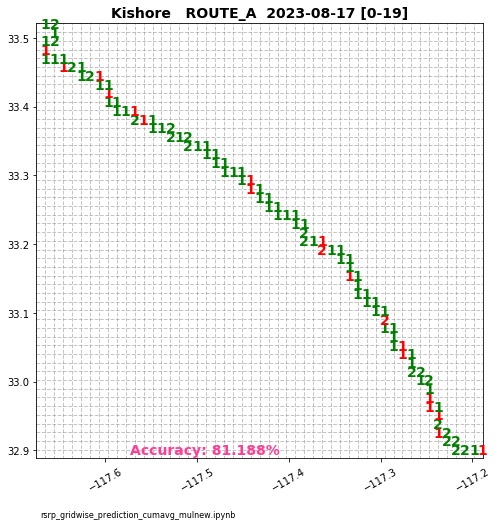

In [23]:
for jj in range(0,rfls-1):
    fig,ax = plt.subplots(figsize=(8,8))
    ax.set_facecolor('white')
    
    rlon = glon[jj,:]; rlat = glat[jj,:]
    rpnts = gpnts[jj,:]; rclss_txt = cumclss_txt[jj,:]
    obs_cdgt = clss_dgt[jj+1,:]
    pred_cdgt = cumclss_dgt[jj,:]
    
    rpnts[rpnts == 0.0] = np.nan
    sc = ax.scatter(rlon, rlat, c=rpnts, cmap='jet',  s=0., alpha=0.65, linewidths=6)
    obs_cdgt = (np.rint(obs_cdgt)).astype(int)
    pred_cdgt = (np.rint(pred_cdgt)).astype(int)
    #counting numbers greater than zero datat = obs_cdgt[np.where(obs_cdgt >= 0)]
    obscnt = (sum(i>=0 & i <1000. for i in obs_cdgt))
    
    mtot = 0
    for ij in range(len(obs_cdgt)):
        if((obs_cdgt[ij] > 0.0) & (obs_cdgt[ij] < 1000.) & (pred_cdgt[ij] > 0) & (pred_cdgt[ij] <1000.)):
            if(obs_cdgt[ij] == pred_cdgt[ij]):
                mtot += 1
                ax.text(rlon[ij]-0.0005, rlat[ij]-0.0005,obs_cdgt[ij],fontsize=14,weight='bold',color='green') 
            else:
                ax.text(rlon[ij]-0.0005, rlat[ij]-0.0005,obs_cdgt[ij],fontsize=14,weight='bold',color='red')
    for ii in range(ny+1):
        yval = minlatt + deltay*ii
        ax.hlines(y=yval,xmin=minlong, xmax=maxlong,linewidth=1,color='gray',linestyles='--',alpha=0.45)
    for ii in range(nx+1):
        xval = minlong + deltax*ii
        ax.vlines(x=xval,ymin=minlatt-.001, ymax=maxlatt,linewidth=1,color='gray',linestyles='--',alpha=0.45)

    ax.set_xlim(minlong,maxlong)
    ax.set_ylim(minlatt,maxlatt)
    ax.tick_params(axis='x',rotation=30)
#     if(jj ==0):
#         tit = name + '   ' + rte +'  '+dates[jj+1]
#     else:    
#         tit = name + '   ' + rte +'  '+dates[jj+1]+' [0-' +str(jj)+']'
    tit = name + '   ' + rte +'  '+dates[jj+1]+' [0-' +str(jj)+']'
    ax.set_title(tit,fontsize=14,weight='bold')
    plt.annotate(prgname, xy=(0.08,0.02), xycoords='figure fraction', ha='left',color='black',fontsize=8)
    
    #Over all accuracy calc.
    acc = 100.*mtot/obscnt
    overallacc= round(acc,3)
    acctxt = "Accuracy: "+str(overallacc)+'%'
    print(f"observations count: {obscnt}  accurate predictions: {mtot}  overall accuracy: {overallacc}")
    ax.text(rlon[10], rlat[10],acctxt,fontsize=14,weight='bold',color='#FF3E96')
    
        #save image
    outpath= "/local/mnt3/workspace3/Kishore/ML_project_dir/ML_project_env/data_folder/test/signal_prediction_plots/16Aug2023/"
    vfname = outpath+name +'_'+rte+'_'+dates[jj+1]+ '_RSRP_cell_gps_gridwise_observed_cumavg_prdctns.png'
    #print(vfname)
    fig.savefig(vfname)
    
    #plt.close()

In [24]:
for jj in range(0,rfls-1):
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,8))
    rlon = glon[jj,:]; rlat = glat[jj,:]
    rpnts = gpnts[jj,:]
    obs_cdgt = clss_dgt[jj+1,:]
    pred_cdgt = cumclss_dgt[jj,:]
    
    rpnts[rpnts == 0.0] = np.nan
    sc = ax.scatter(rlon, rlat, c=rpnts, cmap='jet',  s=0., alpha=0.65, linewidths=6)
    obs_cdgt = (np.rint(obs_cdgt)).astype(int)
    pred_cdgt = (np.rint(pred_cdgt)).astype(int)
    #counting numbers greater than zero datat = obs_cdgt[np.where(obs_cdgt >= 0)]
    obscnt = (sum(i>=0 & i <1000. for i in obs_cdgt))
    
    #right plot (row=1, column=1)
    rpnts[rpnts == 0.0] = np.nan
    sc = ax1.scatter(rlon, rlat, c=rpnts, cmap='jet',  s=0., alpha=0.65, linewidths=6)
    obs_cdgt = (np.rint(obs_cdgt)).astype(int)
    for ij in range(len(obs_cdgt)):
        if(obs_cdgt[ij] >= 0.0):
            ax1.text(rlon[ij]-0.0005, rlat[ij]-0.0005,obs_cdgt[ij],fontsize=14,weight='bold') 

    for ii in range(ny+1):
        yval = minlatt + deltay*ii
        ax1.hlines(y=yval,xmin=minlong, xmax=maxlong,linewidth=1,color='gray',linestyles='--',alpha=0.45)
    for ii in range(nx+1):
        xval = minlong + deltax*ii
        ax1.vlines(x=xval,ymin=minlatt-.001, ymax=maxlatt,linewidth=1,color='gray',linestyles='--',alpha=0.45)

    tit = name + '   ' + rte +'  '+ ' Observed ' + dates[jj+1]
    ax1.set_title(tit,fontsize=12,weight='bold')
    ax1.set_xlim(minlong,maxlong)
    ax1.set_ylim(minlatt,maxlatt)
    ax1.tick_params(axis='x',rotation=30)
    
    #middle plot (row=1, column=2)
    rpnts[rpnts == 0.0] = np.nan
    sc = ax2.scatter(rlon, rlat, c=rpnts, cmap='jet',  s=0., alpha=0.65, linewidths=6)
    pred_cdgt = (np.rint(pred_cdgt)).astype(int)
    for ij in range(len(obs_cdgt)):
        if(pred_cdgt[ij] >= 0.0):
            ax2.text(rlon[ij]-0.0005, rlat[ij]-0.0005,pred_cdgt[ij],fontsize=14,weight='bold') 

    for ii in range(ny+1):
        yval = minlatt + deltay*ii
        ax2.hlines(y=yval,xmin=minlong, xmax=maxlong,linewidth=1,color='gray',linestyles='--',alpha=0.45)
    for ii in range(nx+1):
        xval = minlong + deltax*ii
        ax2.vlines(x=xval,ymin=minlatt-.001, ymax=maxlatt,linewidth=1,color='gray',linestyles='--',alpha=0.45)
    
    tit = name + '   ' + rte +'  '+ ' Predicted ' + dates[jj]+' [0-' +str(jj)+']'
    ax2.set_title(tit,fontsize=12,weight='bold')
    ax2.set_xlim(minlong,maxlong)
    ax2.set_ylim(minlatt,maxlatt)
    ax2.tick_params(axis='x',rotation=30)
    
    #right plot (row=1, column=3)
    mtot = 0
    for ij in range(len(obs_cdgt)):
        if((obs_cdgt[ij] > 0.0) & (obs_cdgt[ij] < 1000.) & (pred_cdgt[ij] > 0) & (pred_cdgt[ij] <1000.)):
            if(obs_cdgt[ij] == pred_cdgt[ij]):
                mtot += 1
                ax3.text(rlon[ij]-0.0005, rlat[ij]-0.0005,obs_cdgt[ij],fontsize=14,weight='bold',color='green') 
            else:
                ax3.text(rlon[ij]-0.0005, rlat[ij]-0.0005,obs_cdgt[ij],fontsize=14,weight='bold',color='red')
    for ii in range(ny+1):
        yval = minlatt + deltay*ii
        ax3.hlines(y=yval,xmin=minlong, xmax=maxlong,linewidth=1,color='gray',linestyles='--',alpha=0.45)
    for ii in range(nx+1):
        xval = minlong + deltax*ii
        ax3.vlines(x=xval,ymin=minlatt-.001, ymax=maxlatt,linewidth=1,color='gray',linestyles='--',alpha=0.45)

    ax3.set_xlim(minlong,maxlong)
    ax3.set_ylim(minlatt,maxlatt)
    ax3.tick_params(axis='x',rotation=30)
#     if(jj ==0):
#         tit = name + '   ' + rte +'  '+dates[jj+1]
#     else:    
#         tit = name + '   ' + rte +'  '+dates[jj+1]+' [0-' +str(jj)+']'
    tit = name + '   ' + rte +'  '+dates[jj+1]+' [0-' +str(jj)+']'
    ax3.set_title(tit,fontsize=14,weight='bold')
    plt.annotate(prgname, xy=(0.08,0.02), xycoords='figure fraction', ha='left',color='black',fontsize=8)
    
    #Over all accuracy calc.
    acc = 100.*mtot/obscnt
    overallacc= round(acc,3)
    acctxt = "Accuracy: "+str(overallacc)+'%'
    print(f"observations count: {obscnt}  accurate predictions: {mtot}  overall accuracy: {overallacc}")
    ax3.text(rlon[10], rlat[10],acctxt,fontsize=14,weight='bold',color='#FF3E96')
 
    plt.close()

observations count: 100  accurate predictions: 84  overall accuracy: 84.0
observations count: 101  accurate predictions: 82  overall accuracy: 81.188
observations count: 101  accurate predictions: 79  overall accuracy: 78.218
observations count: 101  accurate predictions: 82  overall accuracy: 81.188
observations count: 101  accurate predictions: 77  overall accuracy: 76.238
observations count: 99  accurate predictions: 86  overall accuracy: 86.869
observations count: 99  accurate predictions: 85  overall accuracy: 85.859
observations count: 99  accurate predictions: 84  overall accuracy: 84.848
observations count: 101  accurate predictions: 83  overall accuracy: 82.178
observations count: 100  accurate predictions: 85  overall accuracy: 85.0
observations count: 98  accurate predictions: 82  overall accuracy: 83.673
observations count: 100  accurate predictions: 84  overall accuracy: 84.0
observations count: 101  accurate predictions: 73  overall accuracy: 72.277
observations count: 98